# Spotify Playlist Personalisation

----

### 1. Set Environmental variables

Use auth_example.env as a sample. Provide all 3 secrets set in your spotify developer platform

* SPOTIFY_CLIENT_ID=
* SPOTIFY_CLIENT_SECRET=
* SPOTIFY_REDIRECT_URI=


In [1]:
from dotenv import load_dotenv

# Load .env file
load_dotenv()


True

### 2. Generate Token
Provide call back link to generate token for use

In [2]:
import tekore as tk
conf = tk.config_from_environment()
token = tk.prompt_for_user_token(*conf)


Opening browser for Spotify login...


### 3. Retrieving Playlist & Track Data

Reference util.py for additional functionality for data pull.

Utilising tekore package to interact with Spotify API.


In [3]:
from util import *
import asyncio
import pandas as pd

async_spotify = tk.Spotify(token = token, asynchronous=True)
uri = 'spotify:user:gingerale3'
userID = 'gingerale3'

In [4]:
a = await fetch_playlists(async_spotify, userID)

In [5]:
playlist_ids = []
for i, playlist in enumerate(a):
    # if playlist.owner.uri != uri:
    #     continue
    playlist_ids.append((playlist.id, playlist.name))

In [6]:
async def get_playlist_tracks_ids(spotify, playlistID: str, playlistName: str):
    playlistTracks = []
    inital_response = await spotify.playlist_items(playlistID, limit = 1, offset = 0)
    total = inital_response.total 
    playlistTracks.extend({"playlistID": playlistID, "name": playlistName, "track": item} for item in inital_response.items)
    limit = 50
    numOfCalls = (total - 1)//limit + 1

    tasks = [spotify.playlist_items(playlistID, limit = limit, offset = 1 + limit * i) for i in range(numOfCalls)]
    responses = await asyncio.gather(*tasks)
    for response in responses:
        playlistTracks.extend({"playlistID": playlistID, "name": playlistName, "track": item} for item in response.items)

    return playlistTracks


In [7]:
playlistTracks = []
for i in range(len(playlist_ids)//3 + 1):
    tasks = [get_playlist_tracks_ids(async_spotify, id[0], id[1]) for id in playlist_ids[i*3:(i+1)*3]]
    responses = await asyncio.gather(*tasks)
    for response in responses:
        playlistTracks.extend(response)

In [8]:
len(playlistTracks)

2120

In [43]:
# Track id and corresponding playlist
trackId_playlist = []

for tracks in playlistTracks:
    if tracks['track'].track.id is None:
        continue
    trackId_playlist.append({
        'playlistID': tracks['playlistID'],
        'playlistName': tracks['name'],
        'id': tracks['track'].track.id,
        'trackName': tracks['track'].track.name,
        'trackArtist': [artist.name for artist in tracks['track'].track.artists]
        }
    )

In [45]:
len(set([(tracks['playlistID'], tracks['track'].track.id)  for tracks in playlistTracks]))

2117

In [46]:
# Get all features for tracks
track_features = await get_tracks_audio_features(async_spotify, tracks = [track['id'] for track in trackId_playlist])
track_features = [track.__dict__ for track in track_features if track is not None]
track_features_df = pd.DataFrame(track_features).drop_duplicates()
df = pd.DataFrame(trackId_playlist).merge(track_features_df, on = 'id', how = 'left')


In [47]:
# Add description playlist descriptions
len(playlist_ids)

19

In [48]:
# Create consolidate dataframe

In [49]:
features = [
    'acousticness', 
    'danceability',
    'energy',
    'instrumentalness',
    # 'key',
    'liveness',
    # 'loudness',
    # 'mode',
    'speechiness',
    # 'tempo',
    # 'time_signature',
    'valence'
]

df_clean = df.dropna(subset=features)

# ### What if i scaled the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_clean[features] = scaler.fit_transform(df_clean[features])

c:\Users\alexc\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### Modelling

3 Steps
* Feature extraction (can be expanded with more features). But for now lets use spotifys default features
* Clustering/classification
    *  For now lets use k means (see how can we decide how many clusters)
* Natural language generation
    * We'll construct a template for each label or category (as we get more data)
    * Can evolve using a transformer or LLM trained on a relevant dataset(this/template)




Note:

Chose to cluster tracks before giving a label. Becomes from TSNE graphical nature it was clear my playlists do vary within myself. Which aligns with my assumption.
Hence for now - perform clustering. Label the following clusters.

Can look to evolve each step


### K means clustering + Elbow/Silhouette Method

In [17]:
# Reduce Dataset to just values
X = df_clean[features].values


Based of the graphs below, going for 9 clusters

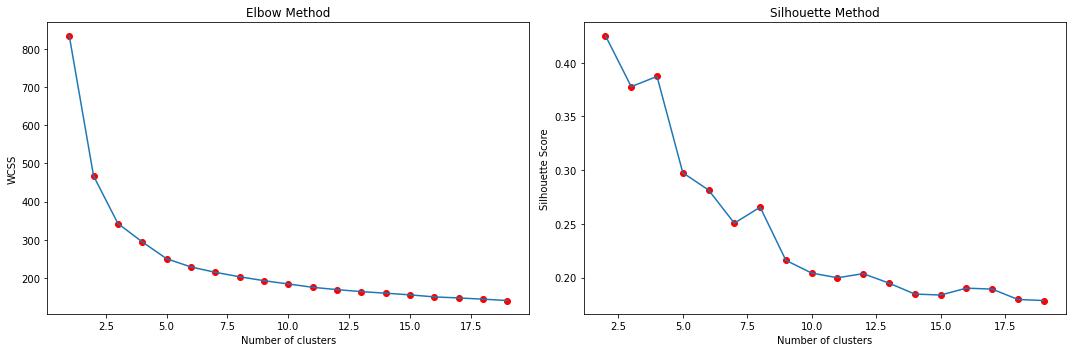

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

wcss = [] # Within-Cluster Sum of Square
silhouette_scores = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state = 16).fit(X)
    #Elbow Method
    wcss.append(kmeans.inertia_)

    #Silhouette
    if i >= 2: #Requires two samples
        label = kmeans.labels_
        sil_coeff = silhouette_score(X, label, metric='euclidean')
        silhouette_scores.append(sil_coeff)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(1, 20), wcss)
axs[0].scatter(range(1, 20), wcss, color='red')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')
# plt.show()



axs[1].plot(range(2, 20), silhouette_scores)
axs[1].scatter(range(2, 20), silhouette_scores, color='red')
axs[1].set_title('Silhouette Method')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')
# plt.show()

plt.tight_layout()
plt.show()


### Chosen algo and hyperparameter


In [58]:
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=1000, n_init=10, random_state = 16).fit(X)
df_clean['kmeans_cluster'] = kmeans.labels_ ## Adding k means cluster to original dataset

<ipython-input-58-9470275ac676>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['kmeans_cluster'] = kmeans.labels_ ## Adding k means cluster to original dataset


### Visualising/Describing each cluster

##### Adding TSNE to visualise cluster across two dimensions

In [65]:
from sklearn.manifold import TSNE

# Extract the features from the dataframe
data_subset = df_clean[features].values

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state = 27)
tsne_results = tsne.fit_transform(data_subset)

# Add the t-SNE results back into the dataframe
df_clean['tsne-2d-one'] = tsne_results[:,0]
df_clean['tsne-2d-two'] = tsne_results[:,1]



<ipython-input-65-c1c884a0b5f3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tsne-2d-one'] = tsne_results[:,0]
<ipython-input-65-c1c884a0b5f3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tsne-2d-two'] = tsne_results[:,1]


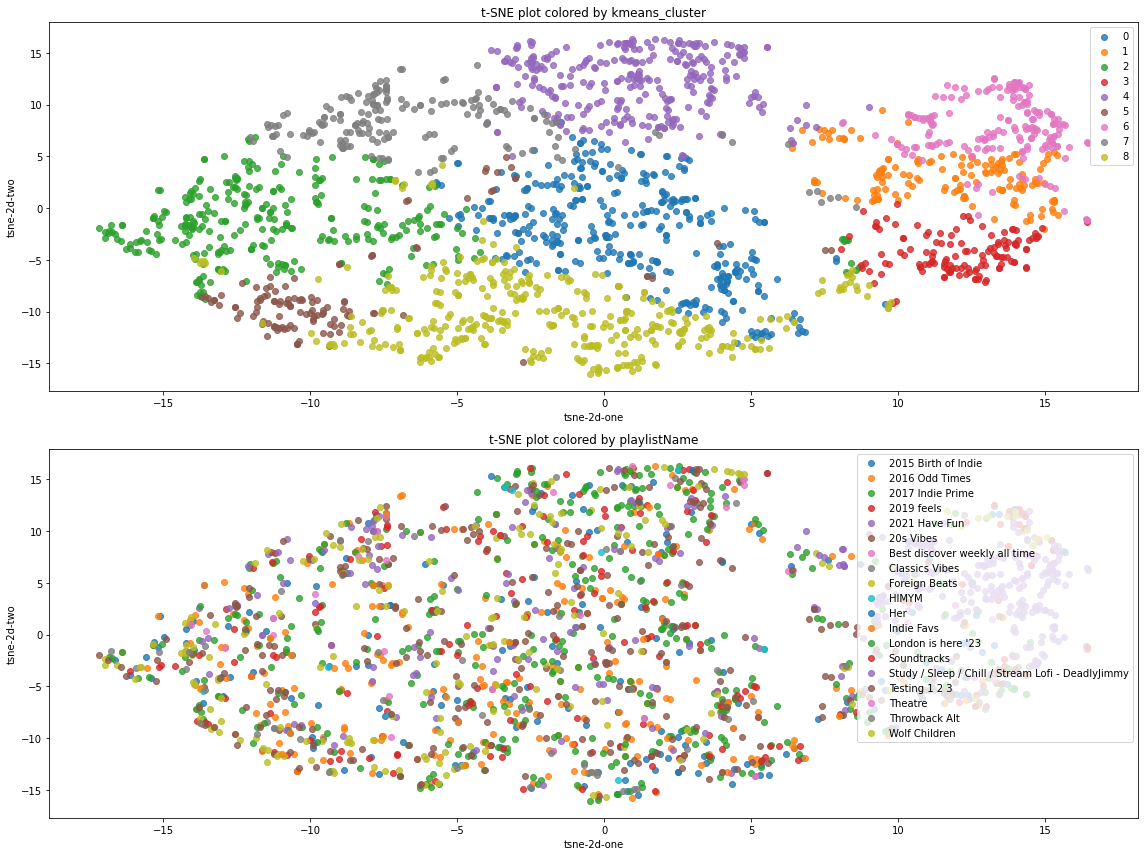

In [66]:
# Set plot size
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

# Create a plot

# Scatter plot for each playlist
for cluster, group in df_clean.groupby('kmeans_cluster'):
    axs[0].scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.8, label=cluster)

axs[0].legend()
axs[0].set_title('t-SNE plot colored by kmeans_cluster')
axs[0].set_xlabel('tsne-2d-one')
axs[0].set_ylabel('tsne-2d-two')



## Plalist
for playlist, group in df_clean.groupby('playlistName'):
    axs[1].scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.8, label=playlist)

axs[1].legend(loc = 'upper right')
axs[1].set_title('t-SNE plot colored by playlistName')
axs[1].set_xlabel('tsne-2d-one')
axs[1].set_ylabel('tsne-2d-two')


plt.tight_layout()
plt.show()





### Worded template for each cluster

As we continue to evolve for the future and potential LLM use. For now using my knowledge of my playlist I will classify and describe each cluster

- 0: "Featuring a slow tempo but compelling rhythm, this song invites you to sway along, albeit with a tinge of sadness or anger. It's a heartfelt narrative wrapped in danceable beats, suitable for moments when you want to dance away your blues."
- 1 "This playlist is rich in emotional depth. With low energy and a sober tone, it offers a contemplative musical experience, ideal for moments of quiet introspection, late-night thoughts."
- 2: "Absolute banger with electrifying, high-energy beats that'll compel you to move your feet. It carries a contagious positive atmosphere, spreading euphoria and joy with each beat. Perfect for parties, gatherings, or when you just need a pick-me-up."
- 3: "Strikes a balance between energy and danceability, making it versatile for various moods and settings. Depending on the emotional tone—be it happiness, melancholy, anger, or euphoria—it can serve as a fitting playlist for a quiet evening, a casual gathering, or introspective moments"
- 4: "For those drives home when you are in a melancholic mood" 
- 5: "Playlist with an electrifying, high-energy beat that'll compel you to move your feet. It carries a contagious positive atmosphere, spreading euphoria and joy with each beat. Perfect for parties, gatherings, or when you just need a pick-me-up."
- 6: "Lofi and sombre tone. Embrace the contemplative experience"
- 7: "A gentle head bouncing inducing playlist. For those afternoon walks."
- 8: "An indie rock experience"

Understanding features further

For all Spotify tracks - you can retrieve it’s features. Deeper information can be found https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

- Features to be mapped
    - Acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
    - Danceability: A value of 0.0 is least danceable and 1.0 is most danceable.
    - Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
    - Instrumentalness: Predicts whether a track contains no vocals.
    - Liveness: Higher liveness values represent an increased probability that the track was performed live
    - Spechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value
    - Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

#### Saving model for serving

* Model to assign cluster 1-8
* Json to match current cluster to generic template

In [ ]:
from joblib import dump

# assuming kmeans is your trained model
dump(kmeans, 'kmeans.joblib') 

In [116]:
import json
json_template = {
    0: "Featuring a slow tempo but compelling rhythm, this song invites you to sway along, albeit with a tinge of sadness or anger. It's a heartfelt narrative wrapped in danceable beats, suitable for moments when you want to dance away your blues.",
    1: "This playlist is rich in emotional depth. With low energy and a sober tone, it offers a contemplative musical experience, ideal for moments of quiet introspection, late-night thoughts.",
    2: "Absolute banger with electrifying, high-energy beats that'll compel you to move your feet. It carries a contagious positive atmosphere, spreading euphoria and joy with each beat. Perfect for parties, gatherings, or when you just need a pick-me-up.",
    3: "Strikes a balance between energy and danceability, making it versatile for various moods and settings. Depending on the emotional tone—be it happiness, melancholy, anger, or euphoria—it can serve as a fitting playlist for a quiet evening, a casual gathering, or introspective moments",
    4: "For those drives home when you are in a melancholic mood",
    5: "Playlist with an electrifying, high-energy beat that'll compel you to move your feet. It carries a contagious positive atmosphere, spreading euphoria and joy with each beat. Perfect for parties, gatherings, or when you just need a pick-me-up.",
    6: "Lofi and sombre tone. Embrace the contemplative experience",
    7: "A gentle head bouncing inducing playlist. For those afternoon walks.",
    8: "An indie rock experience"
}

with open("cluster_template.json", "w") as outfile:
    json.dump(json_template, outfile)

### Scoring sample playlist and attach message